# **1 - General Tasks**

In [ ]:
import numpy as np

## **1.1 - Define the Fully connected multilayer feed forward neural network class**

In [ ]:
class FullyConnectedNeuralNetwork:
    def __init__(self, input_size, output_size, hidden_layers, loss_function, learning_rate=0.01, l1_reg=0.0, l2_reg=0.0):
        """
        Initializes the neural network with the given architecture, specified loss function, and learning rate.

        Parameters:
        - input_size (int): The size of the input layer (number of input features).
        - output_size (int): The size of the output layer (number of output classes or values).
        - hidden_layers (list): List of integers specifying the number of nodes in each hidden layer.
        - loss_function (str): String indicating the type of loss function to use ('mse' for mean squared error, etc.).
        - learning_rate (float): The learning rate for the training process. Default is 0.01.
        """
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        self.loss_function = loss_function
        self.learning_rate = learning_rate  # Set the learning rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg

        # Initialize network architecture
        self.weights = []  # List to store weights matrices
        self.biases = []   # List to store bias vectors
        self._initialize_weights_biases()

    def _initialize_weights_biases(self):
        """
        Initializes weights and biases for all layers in the network using small random values.
        """
        # Create a list of all layer sizes (input layer + hidden layers + output layer)
        layer_sizes = [self.input_size] + self.hidden_layers + [self.output_size]

        # Initialize weights and biases for each layer
        for i in range(len(layer_sizes) - 1):
            # Weight matrix shape: (current layer size, next layer size)
            weight_matrix = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01
            # Bias vector shape: (next layer size,)
            bias_vector = np.zeros((layer_sizes[i+1],))

            self.weights.append(weight_matrix)
            self.biases.append(bias_vector)

    def relu(self, Z):
        """
        Applies the ReLU activation function element-wise to the input array.

        Parameters:
        - Z (np.array): The input array to the activation function.

        Returns:
        - np.array: Output after applying the ReLU activation function.
        """
        return np.maximum(0, Z)

    def softmax(self, Z):
        """
        Applies the softmax function to each row of the input array.

        Parameters:
        - Z (np.array): The input array to the softmax function.

        Returns:
        - np.array: Output after applying the softmax function.
        """
        e_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return e_Z / e_Z.sum(axis=1, keepdims=True)

    def forward_pass(self, X):
        """
        Performs the forward pass through the network and returns the output.

        Parameters:
        - X (np.array): Input data array (batch size, input_size).

        Returns:
        - np.array: The output of the network after passing through all layers.
        """
        A = X  # Initialize A with the input; A will hold the output of the current layer
        activations = []  # List to store intermediate activations for use in backpropagation

        # Iterate through all layers except the last one
        for i in range(len(self.weights) - 1):
            Z = np.dot(A, self.weights[i]) + self.biases[i]  # Compute the linear combination
            A = self.relu(Z)  # Apply ReLU activation function
            activations.append(A)  # Store the activation for later use

        # Last layer (output layer)
        Z_final = np.dot(A, self.weights[-1]) + self.biases[-1]
        if self.loss_function == 'crossentropy':
            # Use softmax for classification tasks
            A_final = self.softmax(Z_final)
        else:
            # For regression tasks (or other tasks not using softmax), apply a linear activation
            A_final = Z_final  # Linear activation for the output layer

        activations.append(A_final)  # Store final activation

        return A_final, activations

    def compute_loss(self, predicted, actual):
        """
        Computes the loss using the specified loss function, adding L1 and L2 regularization penalties.

        Parameters:
        - predicted (np.array): Predicted probabilities or values from the forward pass.
        - actual (np.array): Actual labels (for classification) or values (for regression).

        Returns:
        - float: The computed loss, including regularization penalties.
        """
        m = actual.shape[0]  # Number of examples
        # Base loss calculation
        if self.loss_function == 'crossentropy':
          log_probs = -np.log(predicted[range(m), actual.argmax(axis=1)])
          base_loss = np.sum(log_probs) / m
        elif self.loss_function == 'mse':
          base_loss = np.sum((predicted - actual) ** 2) / m
        else:
          raise ValueError("Unsupported loss function specified.")

        # L1 Regularization
        l1_loss = 0
        if self.l1_reg > 0:
          l1_loss = np.sum([np.sum(np.abs(w)) for w in self.weights])

        # L2 Regularization
        l2_loss = 0
        if self.l2_reg > 0:
          l2_loss = np.sum([np.sum(w ** 2) for w in self.weights])

        # Total loss with L1 and L2 regularization
        total_loss = base_loss + (self.l1_reg * l1_loss) + (self.l2_reg * l2_loss) / (2 * m)

        return total_loss


    def backpropagate(self, input_data, actual, activations):
        """
        Performs backpropagation and updates weights and biases based on the computed gradients,
        including L1 and L2 regularization adjustments.

        Parameters:
        - input_data (np.array): Input data batch.
        - actual (np.array): Actual labels for classification or values for regression.
        - activations (list): List of activations from the forward pass.
        """
        gradients = []  # To store gradients for weights and biases
        m = actual.shape[0]  # Number of examples

        # Start with the gradient of the loss w.r.t. the final activation
        if self.loss_function == 'crossentropy':
            delta = activations[-1] - actual
        elif self.loss_function == 'mse':
            delta = (activations[-1] - actual) * 1  # Linear activation for output layer

        for i in reversed(range(len(self.weights))):
            A_prev = input_data if i == 0 else activations[i-1]

            # Compute gradients with L2 regularization adjustment
            dW = np.dot(A_prev.T, delta) / m + (self.l2_reg * self.weights[i]) / m
            db = np.sum(delta, axis=0) / m

            # Prepare for next layer's backpropagation, if not at the input layer
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * (A_prev > 0)  # Assuming ReLU activation

            gradients.append((dW, db))

        # Update weights and biases, including L1 regularization handling
        for i in range(len(self.weights)):
            dW, db = gradients[-1-i]

            # L1 regularization adjustment for weights update
            # This simplistic approach adjusts weights directly, simulating sub-gradient for L1
            if self.l1_reg > 0:
                dW += (self.l1_reg * np.sign(self.weights[i])) / m

            self.weights[i] -= self.learning_rate * dW
            self.biases[i] -= self.learning_rate * db

# **2 - Regression Tasks**

**Dataset: Regression_data_multiGen - (2 Features X1, X2 & 3 Targets Y1, Y2, Y3)**

Step 1: Mount Google Drive to Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 2: Load the Dataset

In [ ]:
file_path = '/content/drive/MyDrive/PRNN Assignment 2/regression_data_multiGen_group_25_train.txt'

# Load the dataset
data = np.genfromtxt(file_path, skip_header=1, delimiter='\t')

# Splitting the dataset into features and targets
# Last three columns are the target variables Y_1, Y_2, and Y_3
X = data[:, :2]  # Features
Y = data[:, 2:]  # Targets

# Visualize the first few rows of features and targets to verify
print("Features (first 5 rows):", X[:5], sep='\n')
print("Targets (first 5 rows):", Y[:5], sep='\n')

Features (first 5 rows):
[[-1.11209317  1.23597809]
 [ 1.24791045 -1.4654495 ]
 [-1.34662946  1.27430068]
 [-0.42626431  0.9935499 ]
 [ 1.42208158 -0.28391909]]
Targets (first 5 rows):
[[  2.64738624  12.64977485 -19.05825   ]
 [-26.6661193  -24.54404429  43.25399357]
 [  5.99247733  18.71340225 -19.94543241]
 [  1.90098739  -4.48019276 -10.43251567]
 [ -9.9209723  -14.07978765  13.60612355]]


Step 2: Split the Dataset into 20% test and 80% training data

In [ ]:
import numpy as np
# Define the split ratio
split_ratio = 0.8  # 80% of the data for training

# Calculate the split index
split_index = int(X.shape[0] * split_ratio)

# Shuffle the dataset before splitting
# Create an array of indices and shuffle them
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

# Use the shuffled indices to shuffle features and targets
X_shuffled = X[indices]
Y_shuffled = Y[indices]

# Split the features and targets into training and test sets
X_train = X_shuffled[:split_index]
Y_train = Y_shuffled[:split_index]
X_test = X_shuffled[split_index:]
Y_test = Y_shuffled[split_index:]

# Print the shapes of the splits to verify
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (11200, 2)
Y_train shape: (11200, 3)
X_test shape: (2800, 2)
Y_test shape: (2800, 3)


Step 3: Initialize the Model

In [ ]:
# Initialize the model with L1 regularization
model_L1 = FullyConnectedNeuralNetwork(input_size=2,
                                       output_size=3,
                                       hidden_layers=[64, 64],
                                       loss_function='mse',
                                       learning_rate=0.01,
                                       l1_reg=0.01,  # L1 regularization strength
                                       l2_reg=0.0)

# Initialize the model with L2 regularization
model_L2 = FullyConnectedNeuralNetwork(input_size=2,
                                       output_size=3,
                                       hidden_layers=[64, 64],
                                       loss_function='mse',
                                       learning_rate=0.01,
                                       l1_reg=0.0,
                                       l2_reg=0.01)  # L2 regularization strength

print("Model with L1 regularization and model with L2 regularization initialized successfully.")

Model with L1 regularization and model with L2 regularization initialized successfully.


Step 4: Training the Models

In [ ]:
def train_model(model, X_train, Y_train, X_val, Y_val, epochs=100, batch_size=32):
    n_samples = X_train.shape[0]
    n_batches = n_samples // batch_size

    # Initialize lists to store loss history
    training_loss_history = []
    validation_loss_history = []

    # Training loop
    for epoch in range(epochs):
        # Variable to accumulate loss over the epoch
        accumulated_loss = 0

        # Shuffle the dataset at the beginning of each epoch
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        X_train_shuffled = X_train[indices]
        Y_train_shuffled = Y_train[indices]

        # Mini-batch training
        for i in range(n_batches):
            start_index = i * batch_size
            end_index = start_index + batch_size
            X_batch = X_train_shuffled[start_index:end_index]
            Y_batch = Y_train_shuffled[start_index:end_index]

            # Forward pass and loss calculation
            predictions, activations = model.forward_pass(X_batch)
            loss = model.compute_loss(predictions, Y_batch)

            # Backpropagation and parameter update
            model.backpropagate(X_batch, Y_batch, activations)

            accumulated_loss += loss

        # Average training loss for this epoch
        average_training_loss = accumulated_loss / n_batches
        training_loss_history.append(average_training_loss)

        # Validation loss at the end of the epoch
        predictions_val, _ = model.forward_pass(X_val)
        validation_loss = model.compute_loss(predictions_val, Y_val)
        validation_loss_history.append(validation_loss)

        # Print the epoch number and losses
        print(f"Epoch {epoch+1}, Training Loss: {average_training_loss}, Validation Loss: {validation_loss}")

    return training_loss_history, validation_loss_history

Step 5: Training and validation loss over epochs

Epoch 1, Training Loss: 15.564085443990418, Validation Loss: 15.560844826129859
Epoch 2, Training Loss: 15.554674965563517, Validation Loss: 15.604875572256036
Epoch 3, Training Loss: 15.581517024955273, Validation Loss: 15.607428527437955
Epoch 4, Training Loss: 15.544832229975277, Validation Loss: 15.565068833330747
Epoch 5, Training Loss: 15.502938352434994, Validation Loss: 15.93825859206107
Epoch 6, Training Loss: 15.552926663916422, Validation Loss: 15.543267085292126
Epoch 7, Training Loss: 15.52208842186834, Validation Loss: 15.642787918384451
Epoch 8, Training Loss: 15.535980202845863, Validation Loss: 16.057396915147773
Epoch 9, Training Loss: 15.524714785561963, Validation Loss: 15.763225589068002
Epoch 10, Training Loss: 15.528101341280664, Validation Loss: 15.646830843047553
Epoch 11, Training Loss: 15.507804753680286, Validation Loss: 15.470651685716895
Epoch 12, Training Loss: 15.498132946655545, Validation Loss: 15.736675553549187
Epoch 13, Training Loss: 15.52837539813

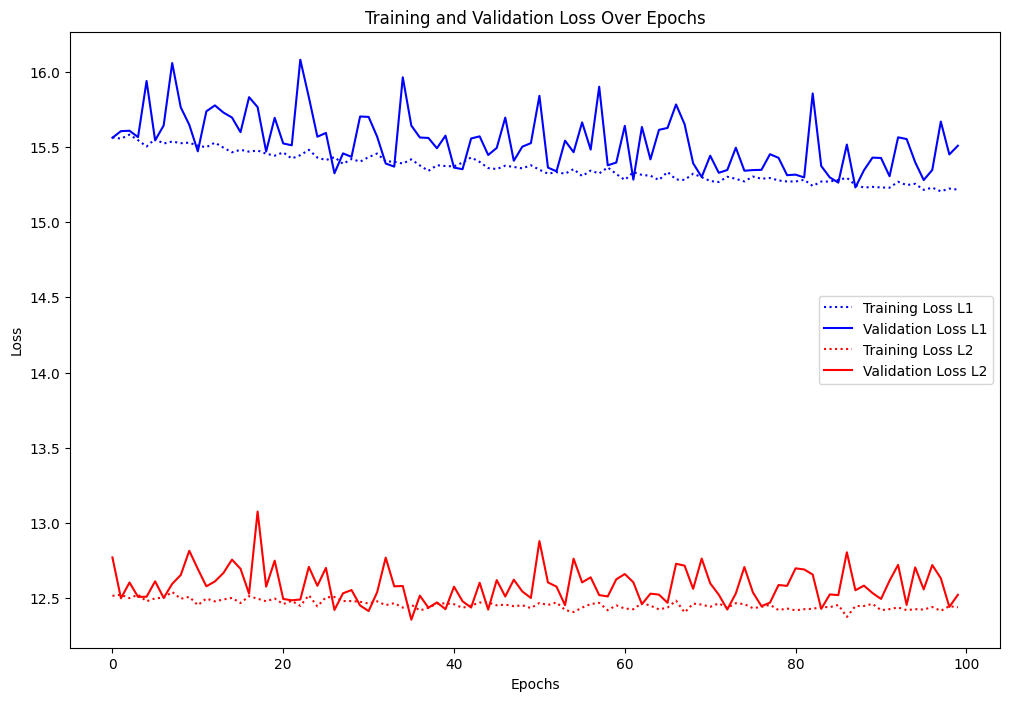

In [ ]:
import matplotlib.pyplot as plt

training_loss_L1, validation_loss_L1 = train_model(model_L1, X_train, Y_train, X_test, Y_test, epochs=100, batch_size=32)
training_loss_L2, validation_loss_L2 = train_model(model_L2, X_train, Y_train, X_test, Y_test, epochs=100, batch_size=32)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(training_loss_L1, label='Training Loss L1', color='blue', linestyle='dotted')
plt.plot(validation_loss_L1, label='Validation Loss L1', color='blue', linestyle='solid')
plt.plot(training_loss_L2, label='Training Loss L2', color='red', linestyle='dotted')
plt.plot(validation_loss_L2, label='Validation Loss L2', color='red', linestyle='solid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

Step 6: Weight distribution with respect to different regularizations

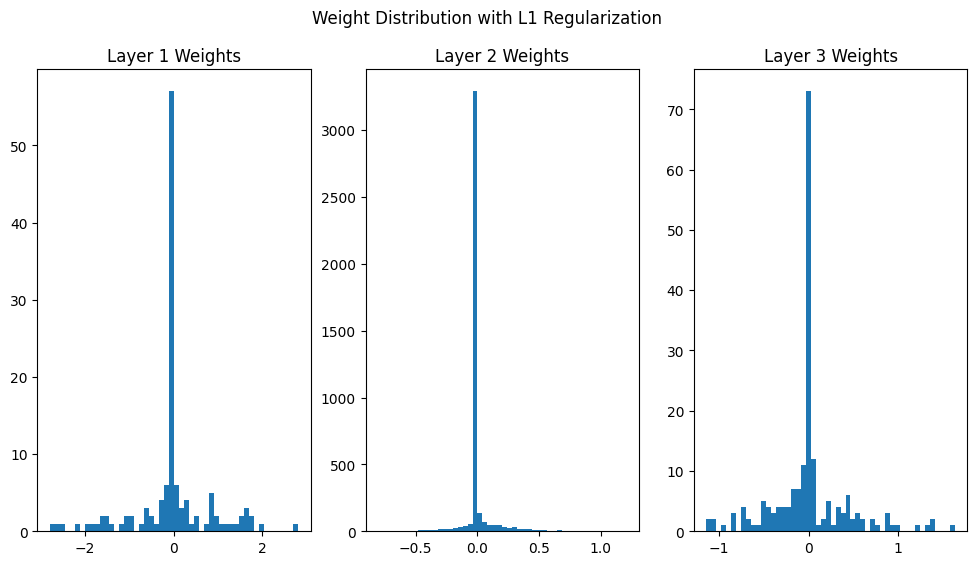

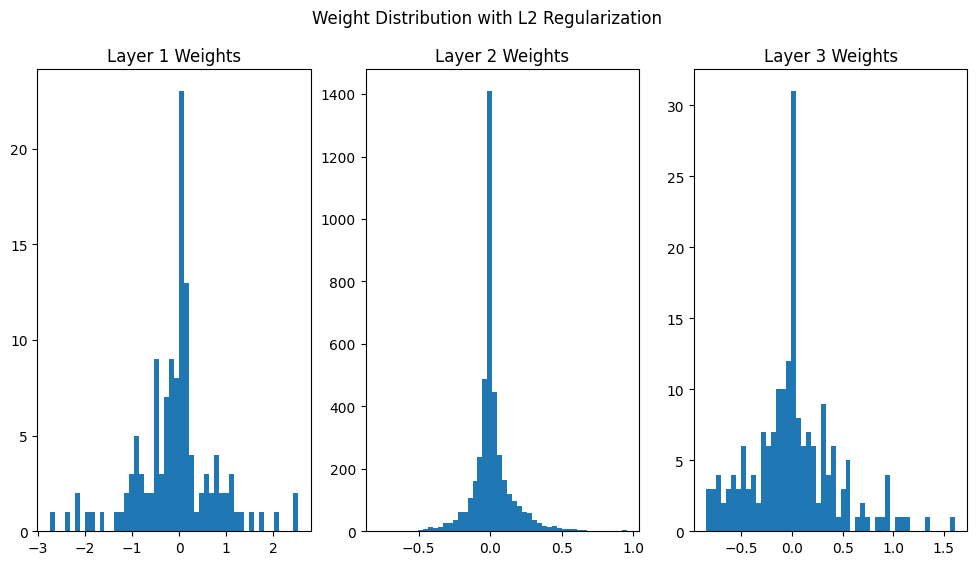

In [ ]:
import matplotlib.pyplot as plt

def plot_weight_distributions(model, title):
    plt.figure(figsize=(12, 6))
    for layer_idx, layer_weights in enumerate(model.weights):
        plt.subplot(1, len(model.weights), layer_idx+1)
        plt.hist(layer_weights.flatten(), bins=50)
        plt.title(f'Layer {layer_idx+1} Weights')
    plt.suptitle(title)
    plt.show()

# Model_L1 and model_L2 are your trained models
plot_weight_distributions(model_L1, 'Weight Distribution with L1 Regularization')
plot_weight_distributions(model_L2, 'Weight Distribution with L2 Regularization')

Step 7: Actual vs. Predicted Outputs

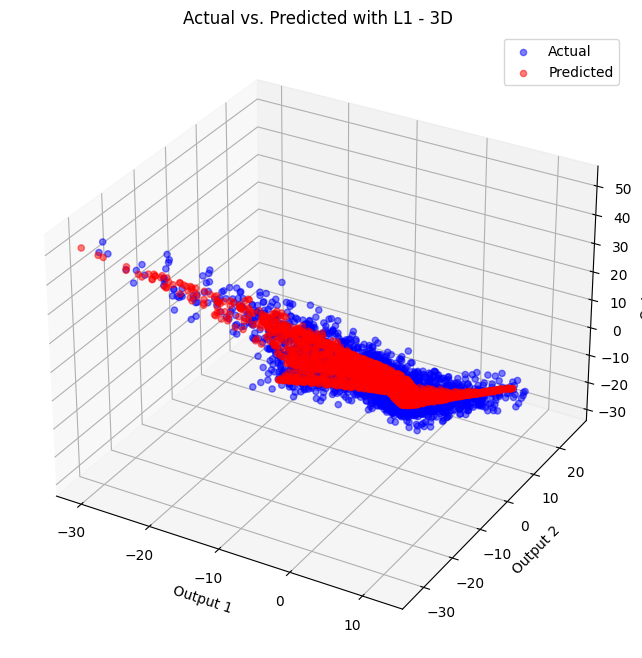

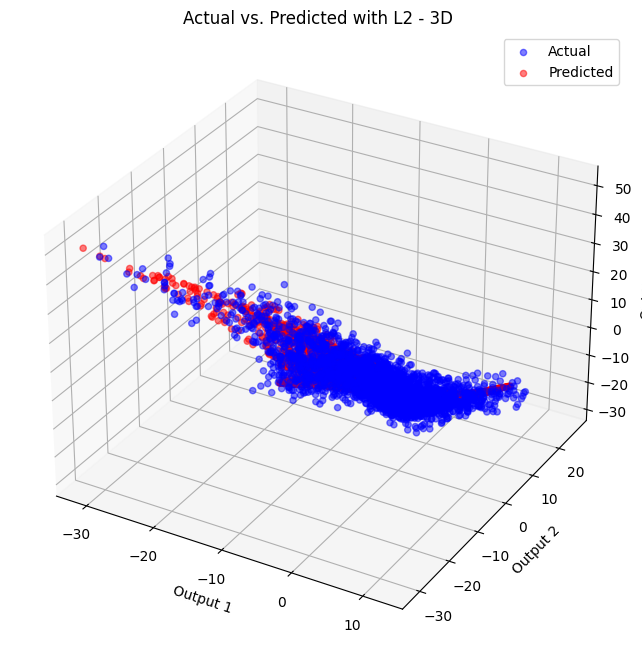

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_actual_vs_predicted_3d(model, X, Y, title):
    predictions, _ = model.forward_pass(X)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], color='b', alpha=0.5, label='Actual')
    ax.scatter(predictions[:, 0], predictions[:, 1], predictions[:, 2], color='r', alpha=0.5, label='Predicted')

    ax.set_xlabel('Output 1')
    ax.set_ylabel('Output 2')
    ax.set_zlabel('Output 3')
    ax.set_title(title)
    ax.legend()

    plt.show()

# Example usage
plot_actual_vs_predicted_3d(model_L1, X_test, Y_test, 'Actual vs. Predicted with L1 - 3D')
plot_actual_vs_predicted_3d(model_L2, X_test, Y_test, 'Actual vs. Predicted with L2 - 3D')

Step 8: Error distribution

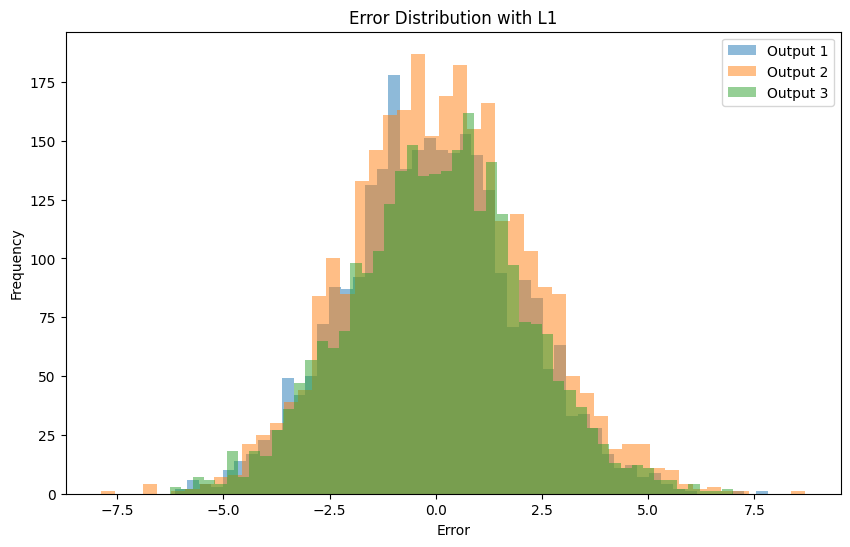

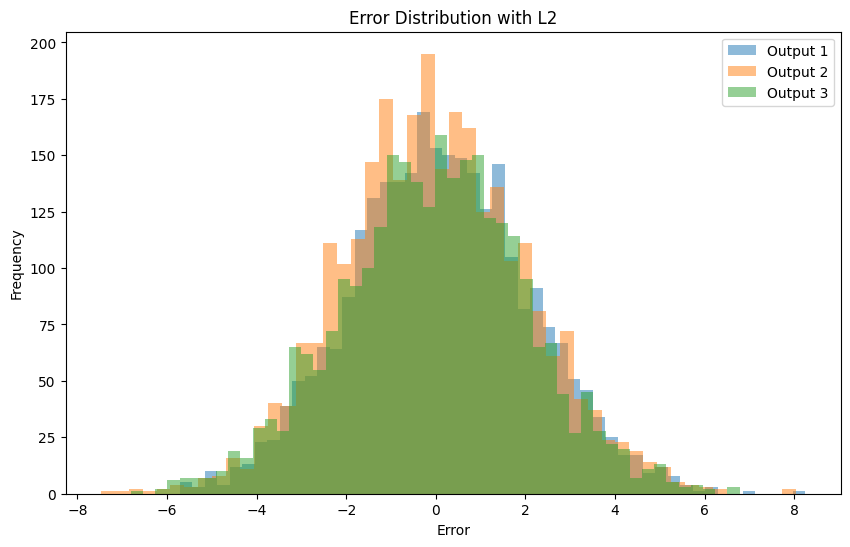

In [ ]:
def plot_error_distribution(model, X, Y, title):
    predictions, _ = model.forward_pass(X)
    errors = Y - predictions
    plt.figure(figsize=(10, 6))
    for output_idx in range(Y.shape[1]):
        plt.hist(errors[:, output_idx], bins=50, alpha=0.5, label=f'Output {output_idx+1}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()

plot_error_distribution(model_L1, X_test, Y_test, 'Error Distribution with L1')
plot_error_distribution(model_L2, X_test, Y_test, 'Error Distribution with L2')

Step 9: Visualize Feature Importance

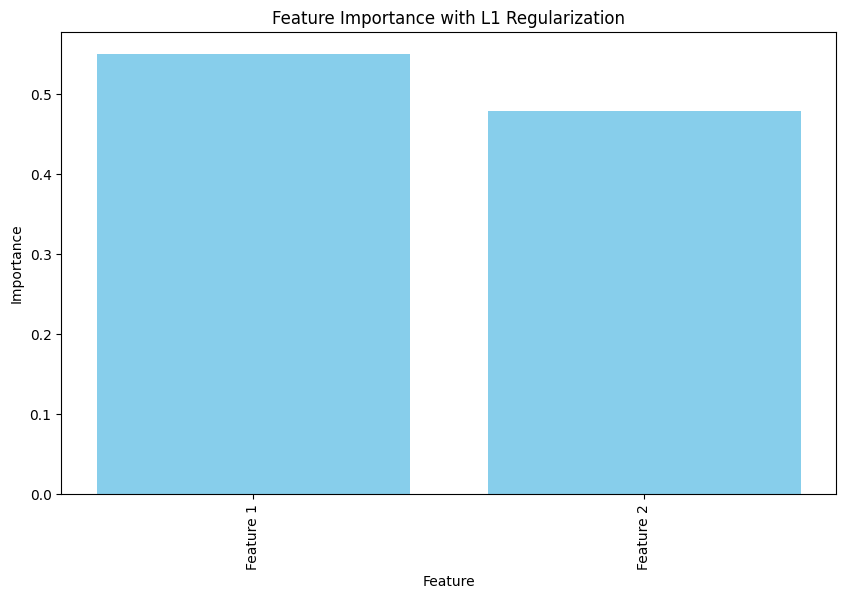

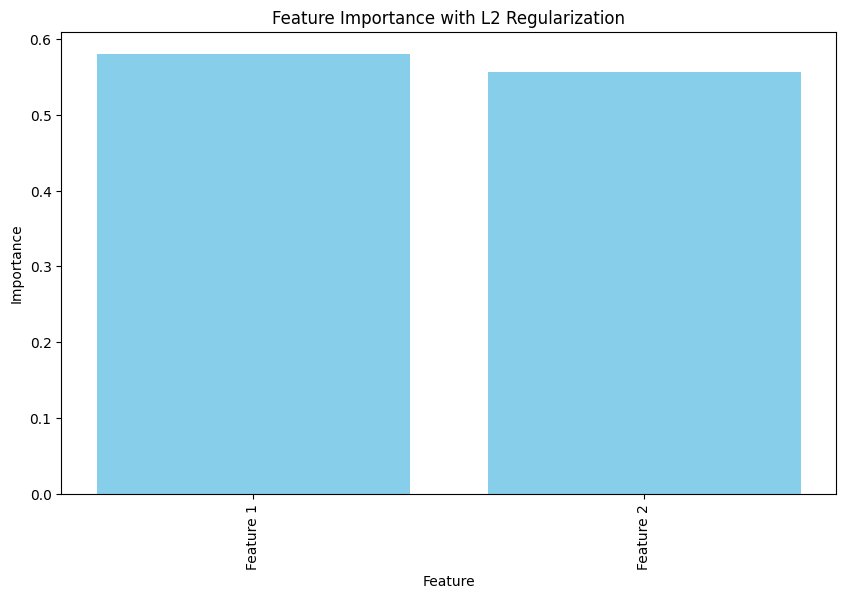

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(weights, feature_names, title):
    """
    Visualize the feature importance based on the magnitude of weights.

    Parameters:
    - weights: Weights of the first layer of the neural network.
    - feature_names: List of names for each feature.
    - title: The title for the plot.
    """
    # Calculate the importance as the absolute value of weights
    importance = np.abs(weights).mean(axis=1)  # Mean across possible multiple outputs

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    indices = np.arange(len(importance))
    plt.bar(indices, importance, color='skyblue')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title(title)
    plt.xticks(indices, feature_names, rotation='vertical')
    plt.show()

feature_names = ['Feature 1', 'Feature 2']

# Plot feature importance for both models
plot_feature_importance(model_L1.weights[0], feature_names, 'Feature Importance with L1 Regularization')
plot_feature_importance(model_L2.weights[0], feature_names, 'Feature Importance with L2 Regularization')

Step 10: Bias variance curves

In [ ]:
l1_values = [0.0, 0.001, 0.01, 0.1, 1.0]
l2_values = [0.0, 0.001, 0.01, 0.1, 1.0]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

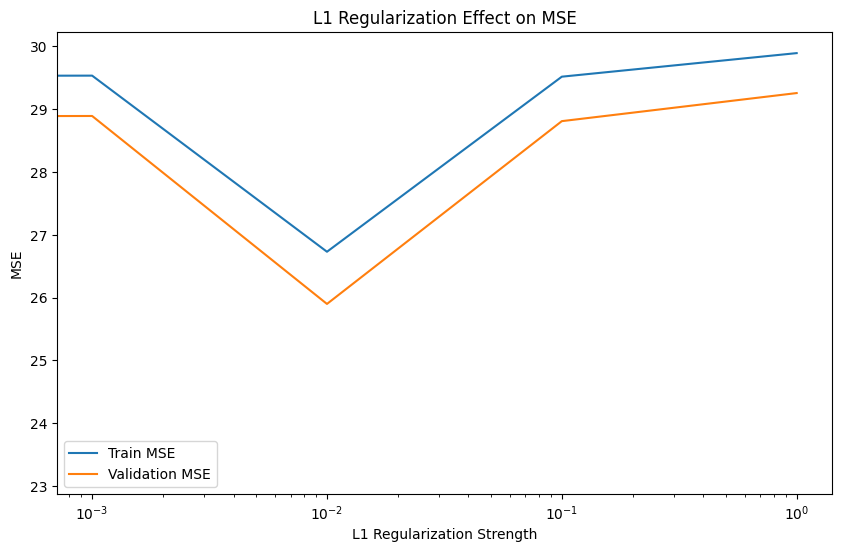

In [ ]:
train_mse_l1 = []
val_mse_l1 = []

for l1_reg in l1_values:
    # Initialize the model with current L1 regularization
    nn = FullyConnectedNeuralNetwork(input_size=2, output_size=3, hidden_layers=[10], loss_function='mse', l1_reg=l1_reg, l2_reg=0.0)

    epochs = 100
    for epoch in range(epochs):
        predictions, activations = nn.forward_pass(X_train)
        nn.backpropagate(X_train, Y_train, activations)

    # Evaluate the model
    train_predictions, _ = nn.forward_pass(X_train)
    val_predictions, _ = nn.forward_pass(X_test)

    # Compute and record MSE
    train_mse_l1.append(compute_mse(Y_train, train_predictions))
    val_mse_l1.append(compute_mse(Y_test, val_predictions))

# Plotting the MSE for training and validation sets
plt.figure(figsize=(10, 6))
plt.plot(l1_values, train_mse_l1, label='Train MSE')
plt.plot(l1_values, val_mse_l1, label='Validation MSE')
plt.xlabel('L1 Regularization Strength')
plt.ylabel('MSE')
plt.title('L1 Regularization Effect on MSE')
plt.legend()
plt.xscale('log')
plt.show()



*   **High Regularization Strength:** Large values for L1 or L2 regularization parameters lead to simpler models by constraining the weights. This simplification can result in higher MSE if the model becomes too simple to capture the underlying pattern, indicative of high bias.
*   **Low Regularization Strength**: Small values for regularization parameters allow the model's weights to grow freely, increasing the model's complexity. This can lower the MSE on training data as the model fits more closely to it, but it can increase MSE on validation data if the model starts to overfit, capturing noise instead of the underlying pattern, indicative of high variance.



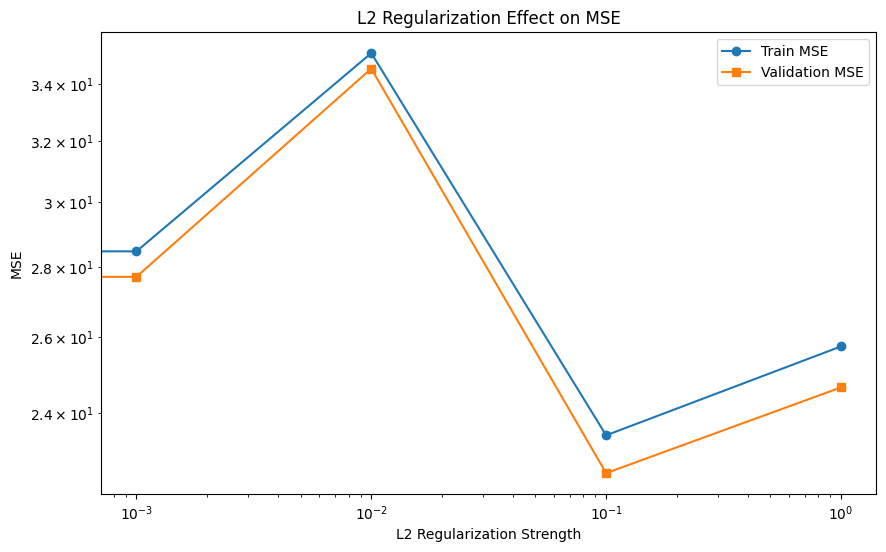

In [ ]:
train_mse_l2 = []
val_mse_l2 = []

for l2_reg in l2_values:
    # Initialize the model with current L2 regularization
    nn = FullyConnectedNeuralNetwork(input_size=2, output_size=3, hidden_layers=[10], loss_function='mse', l1_reg=0.0, l2_reg=l2_reg)

    # Train the model
    epochs = 100
    for epoch in range(epochs):
        predictions, activations = nn.forward_pass(X_train)
        nn.backpropagate(X_train, Y_train, activations)

    # Evaluate the model on both the training and validation sets
    train_predictions, _ = nn.forward_pass(X_train)
    val_predictions, _ = nn.forward_pass(X_test)

    # Compute and append MSE for both datasets
    train_mse_l2.append(compute_mse(Y_train, train_predictions))
    val_mse_l2.append(compute_mse(Y_test, val_predictions))

# Plotting the MSE for both training and validation sets against L2 regularization strengths
plt.figure(figsize=(10, 6))
plt.plot(l2_values, train_mse_l2, label='Train MSE', marker='o')
plt.plot(l2_values, val_mse_l2, label='Validation MSE', marker='s')
plt.xlabel('L2 Regularization Strength')
plt.ylabel('MSE')
plt.title('L2 Regularization Effect on MSE')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

**Dataset: Regression_data_multilinear - (10 Features & 3 Targets)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

file_path = '/content/drive/MyDrive/PRNN Assignment 2/regression_data_multilinear_group_25_train.txt'

# Load the dataset
data = np.loadtxt(file_path, skiprows=1) # skips the header row

In [ ]:
# Calculate the split index
split_idx = int(data.shape[0] * 0.8)

# Split the data
train_data = data[:split_idx]
test_data = data[split_idx:]

# Split into features and targets
X_train = train_data[:, :10] # First 10 columns are features
y_train = train_data[:, 10:] # Last 3 columns are targets

X_test = test_data[:, :10] # Features for testing
y_test = test_data[:, 10:] # Targets for testing

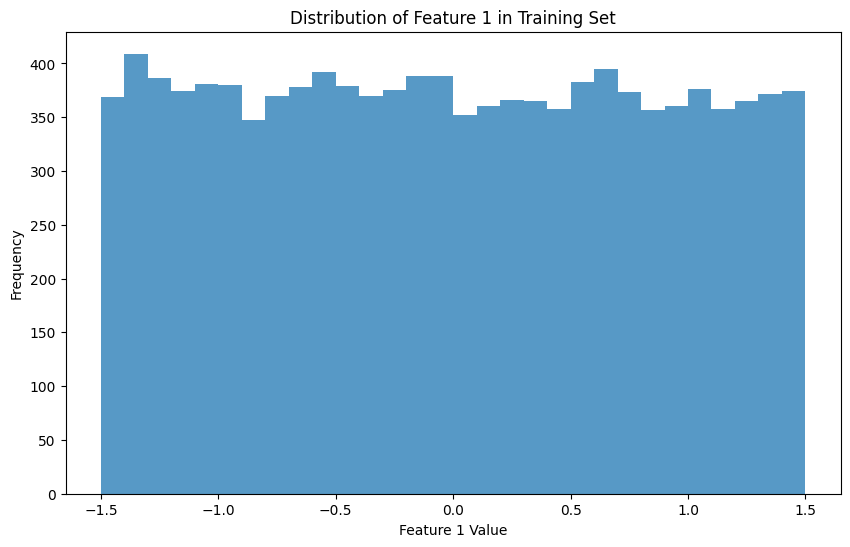

In [ ]:
import matplotlib.pyplot as plt

# Plotting the distribution of the first feature
plt.figure(figsize=(10, 6))
plt.hist(X_train[:, 0], bins=30, alpha=0.75)
plt.title('Distribution of Feature 1 in Training Set')
plt.xlabel('Feature 1 Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Print the shapes of the datasets to ensure they are loaded correctly
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Print the first 5 samples from the training and testing datasets to verify the data
print("\nFirst 5 samples of X_train:")
print(X_train[:5])
print("\nFirst 5 samples of y_train:")
print(y_train[:5])

print("\nFirst 5 samples of X_test:")
print(X_test[:5])
print("\nFirst 5 samples of y_test:")
print(y_test[:5])

# If you want to check for any specific properties or statistics:
print("\nSome statistics:")
print(f"Mean of X_train: {np.mean(X_train, axis=0)}")
print(f"Standard deviation of X_train: {np.std(X_train, axis=0)}")
print(f"Mean of y_train: {np.mean(y_train, axis=0)}")
print(f"Standard deviation of y_train: {np.std(y_train, axis=0)}")

Shape of X_train: (11200, 10)
Shape of y_train: (11200, 3)
Shape of X_test: (2800, 10)
Shape of y_test: (2800, 3)

First 5 samples of X_train:
[[-1.11209317  1.23675121 -1.37538258  1.23597809  1.52764184  1.88813185
  -1.37452279  1.52859741 -1.69888006  1.8893129 ]
 [ 1.24791045  1.55728048  1.94334658 -1.4654495   2.14754223 -3.14711469
  -1.82874974 -2.2821159   2.67994038  3.3443256 ]
 [-1.34662946  1.81341091 -2.44199255  1.27430068  1.62384223  2.06926327
  -1.71601084  2.31083076 -2.18671379  2.94469322]
 [-0.42626431  0.18170126 -0.07745276  0.9935499   0.9871414   0.98077424
  -0.42351486  0.18052927 -0.42078315  0.17936484]
 [ 1.42208158  2.02231602  2.87589837 -0.28391909  0.08061005 -0.02288673
  -0.4037561  -0.57417412  0.11463406  0.16301899]]

First 5 samples of y_train:
[[  2.64738624  12.64977485 -19.05825   ]
 [-26.6661193  -24.54404429  43.25399357]
 [  5.99247733  18.71340225 -19.94543241]
 [  1.90098739  -4.48019276 -10.43251567]
 [ -9.9209723  -14.07978765  13.60

In [ ]:
# Define the neural network architecture
input_size = 10  # Number of features
output_size = 3  # Number of targets
hidden_layers = [64]  # One hidden layer with 64 neurons
learning_rate = 0.01
l1_reg = 0.001
epochs = 10  # Number of epochs for training

# Instantiate the neural network
model = FullyConnectedNeuralNetwork(input_size=input_size,
                                    output_size=output_size,
                                    hidden_layers=hidden_layers,
                                    loss_function='mse',  # MSE for regression type of problem
                                    learning_rate=learning_rate,
                                    l1_reg=l1_reg)

# Training loop
for epoch in range(epochs):
    # Forward pass
    predictions, activations = model.forward_pass(X_train)

    # Compute loss (assuming MSE loss for simplicity)
    loss = model.compute_loss(predictions, y_train)

    # Backpropagate the error and update weights
    model.backpropagate(X_train, y_train, activations)

    # Print the loss every epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss}")

Epoch 1/10, Loss: 239.56075351739597
Epoch 2/10, Loss: 239.03885241559553
Epoch 3/10, Loss: 238.52308368708347
Epoch 4/10, Loss: 238.0054374688398
Epoch 5/10, Loss: 237.47691066752617
Epoch 6/10, Loss: 236.92662967093554
Epoch 7/10, Loss: 236.3409158394915
Epoch 8/10, Loss: 235.69998676560934
Epoch 9/10, Loss: 234.97490467956393
Epoch 10/10, Loss: 234.12497065642373


In [ ]:
# Adjusted neural network architecture
input_size = 10  # Number of features
output_size = 3  # Number of targets
hidden_layers = [128, 64, 32]  # Three hidden layers with different sizes
learning_rate = 0.01
l1_reg = 0.001
epochs = 10  # Number of epochs for training

# Instantiate the neural network with the new architecture
model = FullyConnectedNeuralNetwork(input_size=input_size,
                                    output_size=output_size,
                                    hidden_layers=hidden_layers,
                                    loss_function='mse',  MSE for regression type of problem
                                    learning_rate=learning_rate,
                                    l1_reg=l1_reg)

# Training loop (same as before)
for epoch in range(epochs):
    # Forward pass
    predictions, activations = model.forward_pass(X_train)

    # Compute loss
    loss = model.compute_loss(predictions, y_train)

    # Backpropagate the error and update weights
    model.backpropagate(X_train, y_train, activations)

    # Print the loss every epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss}")

# Consider evaluating the model on X_test and y_test to see the performance

Epoch 1/10, Loss: 239.65539942223867
Epoch 2/10, Loss: 239.18333077640068
Epoch 3/10, Loss: 238.72051021841799
Epoch 4/10, Loss: 238.26689063058615
Epoch 5/10, Loss: 237.8222982712809
Epoch 6/10, Loss: 237.3865462567483
Epoch 7/10, Loss: 236.95945912592984
Epoch 8/10, Loss: 236.54085643325507
Epoch 9/10, Loss: 236.1305695014205
Epoch 10/10, Loss: 235.72842485745053


In [ ]:
def train_and_evaluate(X_train, y_train, X_test, y_test, l1_reg):
    # Model configuration
    input_size = 10
    output_size = 3
    hidden_layers = [128, 64, 32]
    learning_rate = 0.01
    epochs = 10

    # Initialize the model
    model = FullyConnectedNeuralNetwork(input_size, output_size, hidden_layers, 'mse', learning_rate, l1_reg=l1_reg)

    # Train the model
    for epoch in range(epochs):
        predictions, activations = model.forward_pass(X_train)
        model.backpropagate(X_train, y_train, activations)

    # Evaluate on test data
    test_predictions, _ = model.forward_pass(X_test)
    mse = model.compute_loss(test_predictions, y_test)
    return mse

In [ ]:
l1_reg_values = np.logspace(-4, -1, 10)  # Generating 10 values for l1_reg between 0.0001 and 0.1
mse_values = []

for l1_reg in l1_reg_values:
    mse = train_and_evaluate(X_train, y_train, X_test, y_test, l1_reg)
    mse_values.append(mse)
    print(f"L1 regularization: {l1_reg}, MSE: {mse}")

L1 regularization: 0.0001, MSE: 226.18199451719863
L1 regularization: 0.00021544346900318845, MSE: 226.1944082339295
L1 regularization: 0.00046415888336127773, MSE: 226.21947113125165
L1 regularization: 0.001, MSE: 226.26628736768856
L1 regularization: 0.002154434690031882, MSE: 226.369831486919
L1 regularization: 0.004641588833612777, MSE: 226.59694331544762
L1 regularization: 0.01, MSE: 227.0968469225804
L1 regularization: 0.021544346900318822, MSE: 228.16871115399815
L1 regularization: 0.046415888336127774, MSE: 230.45927049367532
L1 regularization: 0.1, MSE: 235.4372777910231


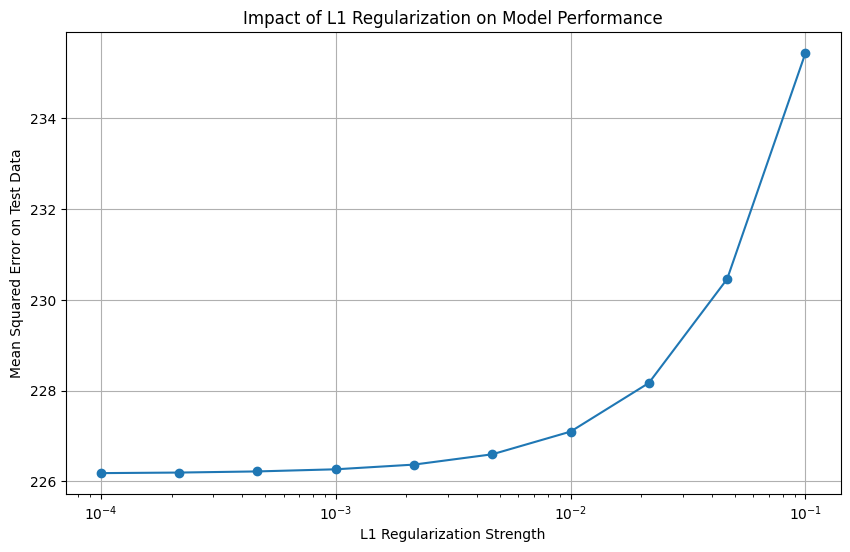

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.semilogx(l1_reg_values, mse_values, marker='o')
plt.xlabel('L1 Regularization Strength')
plt.ylabel('Mean Squared Error on Test Data')
plt.title('Impact of L1 Regularization on Model Performance')
plt.grid(True)
plt.show()

In [ ]:
def train_and_evaluate_l2(X_train, y_train, X_test, y_test, l2_reg):
    # Configuration remains the same except for l2_reg
    input_size = 10
    output_size = 3
    hidden_layers = [128, 64, 32]
    learning_rate = 0.01
    epochs = 10

    # Initialize the model with L2 regularization
    model = FullyConnectedNeuralNetwork(input_size, output_size, hidden_layers, 'mse',
                                        learning_rate, l1_reg=0.0, l2_reg=l2_reg)

    # Train the model
    for epoch in range(epochs):
        predictions, activations = model.forward_pass(X_train)
        model.backpropagate(X_train, y_train, activations)

    # Evaluate on test data
    test_predictions, _ = model.forward_pass(X_test)
    mse = model.compute_loss(test_predictions, y_test)
    return mse

In [ ]:
l2_reg_values = np.logspace(-4, -1, 10)  # 10 values for l2_reg between 0.0001 and 0.1
mse_values_l2 = []

for l2_reg in l2_reg_values:
    mse = train_and_evaluate_l2(X_train, y_train, X_test, y_test, l2_reg)
    mse_values_l2.append(mse)
    print(f"L2 regularization: {l2_reg}, MSE: {mse}")

L2 regularization: 0.0001, MSE: 226.17372557158563
L2 regularization: 0.00021544346900318845, MSE: 226.1718553392462
L2 regularization: 0.00046415888336127773, MSE: 226.17080171899127
L2 regularization: 0.001, MSE: 226.17532880564073
L2 regularization: 0.002154434690031882, MSE: 226.17507979548614
L2 regularization: 0.004641588833612777, MSE: 226.1723352310122
L2 regularization: 0.01, MSE: 226.17595868829775
L2 regularization: 0.021544346900318822, MSE: 226.1756129503877
L2 regularization: 0.046415888336127774, MSE: 226.17184758147798
L2 regularization: 0.1, MSE: 226.17314974978768


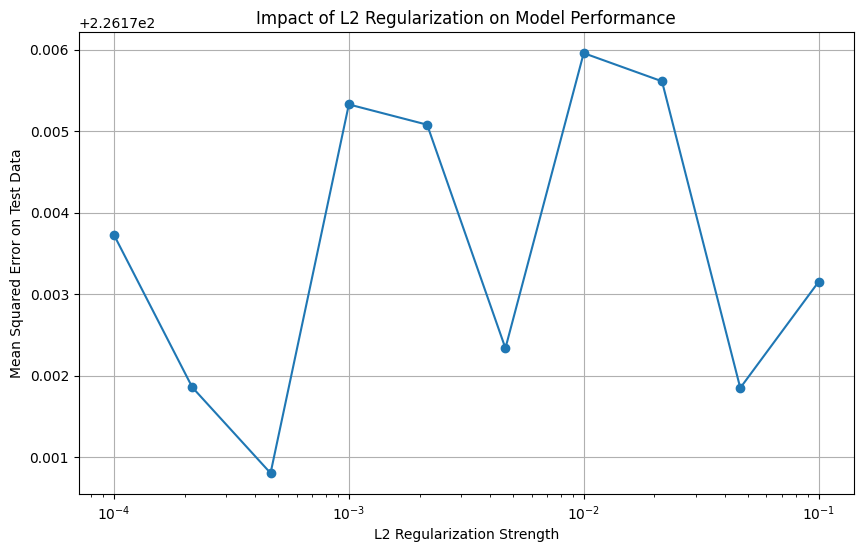

In [ ]:
plt.figure(figsize=(10, 6))
plt.semilogx(l2_reg_values, mse_values_l2, marker='o')
plt.xlabel('L2 Regularization Strength')
plt.ylabel('Mean Squared Error on Test Data')
plt.title('Impact of L2 Regularization on Model Performance')
plt.grid(True)
plt.show()

**Dataset: Regression_data_Uni - (5 Feature & 1 Target)**

In [ ]:
from google.colab import drive
import numpy as np

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Load the dataset
file_path = '/content/drive/MyDrive/PRNN Assignment 2/regression_data_uni_group_25_train.txt'
data = np.loadtxt(file_path, skiprows=1)  # Skip the header row

# Step 3: Split the dataset into training and testing sets
np.random.shuffle(data)  # Randomly shuffle the dataset
split_ratio = 0.8  # 80% for training, 20% for testing
split_index = int(len(data) * split_ratio)

train_data = data[:split_index]
test_data = data[split_index:]

# Separate features and target variable (y)
train_X = train_data[:, :-1]  # All features except the last column
train_y = train_data[:, -1]  # Only the last column

test_X = test_data[:, :-1]
test_y = test_data[:, -1]

# Check shapes of the datasets
print(f"Train X shape: {train_X.shape}")
print(f"Train y shape: {train_y.shape}")
print(f"Test X shape: {test_X.shape}")
print(f"Test y shape: {test_y.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train X shape: (5600, 5)
Train y shape: (5600,)
Test X shape: (1400, 5)
Test y shape: (1400,)


In [ ]:
input_size = train_X.shape[1]  # Number of features
output_size = 1  # For regression
hidden_layers = [10]  # One hidden layer with 10 neurons
loss_function = 'mse'  # Mean Squared Error for regression
learning_rate = 0.01  # Example learning rate

# Instantiate the model
model = FullyConnectedNeuralNetwork(input_size, output_size, hidden_layers, loss_function, learning_rate)

# Placeholder for a training function - to be defined based on the provided class structure
def train_model(model, train_X, train_y, epochs=100):
    for epoch in range(epochs):
        # Forward pass
        predictions, activations = model.forward_pass(train_X)
        loss = model.compute_loss(predictions, train_y.reshape(-1, 1))

        # Backward pass and update weights
        model.backpropagate(train_X, train_y.reshape(-1, 1), activations)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

# Train the model
train_model(model, train_X, train_y, epochs=100)

# Evaluates the performance on the test set
def test_model(model, test_X, test_y):
    predictions, _ = model.forward_pass(test_X)
    loss = model.compute_loss(predictions, test_y.reshape(-1, 1))
    print(f"Test Loss: {loss}")
    return loss

# Test the model
test_model(model, test_X, test_y)

Epoch 0, Loss: 0.19810444973536737
Epoch 10, Loss: 0.18499601191571635
Epoch 20, Loss: 0.1742752364282185
Epoch 30, Loss: 0.16550687745342077
Epoch 40, Loss: 0.1583350333945331
Epoch 50, Loss: 0.15246866988042007
Epoch 60, Loss: 0.1476697875131698
Epoch 70, Loss: 0.1437437490202459
Epoch 80, Loss: 0.14053134187392483
Epoch 90, Loss: 0.1379024822223383
Test Loss: 0.13454530204386453


0.13454530204386453


Training model with L1 regularization strength: 0.0
Epoch 0, Loss: 0.1980944560000239
Epoch 10, Loss: 0.18500412248575523
Epoch 20, Loss: 0.17429836576407426
Epoch 30, Loss: 0.1655430418038075
Epoch 40, Loss: 0.15838280916823477
Epoch 50, Loss: 0.15252706663480942
Epoch 60, Loss: 0.14773815720371256
Epoch 70, Loss: 0.14382172151717562
Epoch 80, Loss: 0.14061880925390158
Epoch 90, Loss: 0.13799942796839623
Test Loss: 0.13465426990671406

Training model with L1 regularization strength: 0.005263157894736842
Epoch 0, Loss: 0.2089075795575705
Epoch 10, Loss: 0.1958233416691063
Epoch 20, Loss: 0.1851217955776674
Epoch 30, Loss: 0.17636890310939396
Epoch 40, Loss: 0.1692098285419285
Epoch 50, Loss: 0.1633543512976783
Epoch 60, Loss: 0.15856509061108742
Epoch 70, Loss: 0.15464789760382747
Epoch 80, Loss: 0.151443974816613
Epoch 90, Loss: 0.14882344072101977
Test Loss: 0.14547699895362448

Training model with L1 regularization strength: 0.010526315789473684
Epoch 0, Loss: 0.21999797159514617
E

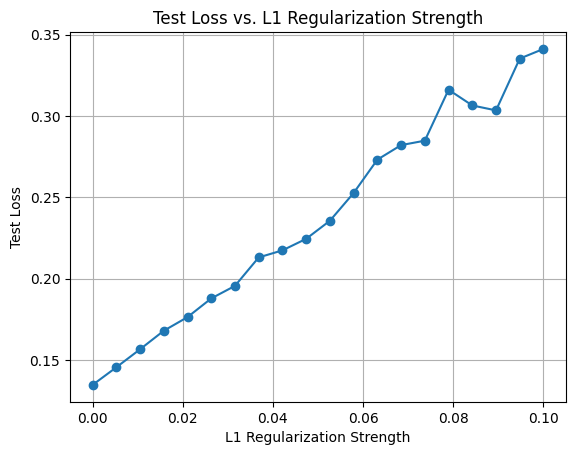

In [ ]:
# Define a range of L1 regularization strengths
l1_strengths = np.linspace(0.0, 0.1, 20)  # 20 values from 0.0 to 0.1

# Define the architecture for the models
input_size = train_X.shape[1]  # Number of features
output_size = 1  # For regression
hidden_layers = [10, 10, 10]  # Example: 3 hidden layers with 10 neurons each
loss_function = 'mse'  # Mean Squared Error for regression

# Store the test loss for each model to analyze later
test_losses = []

# Train and test a model for each L1 strength
for l1_reg in l1_strengths:
    print(f"\nTraining model with L1 regularization strength: {l1_reg}")
    model = FullyConnectedNeuralNetwork(input_size, output_size, hidden_layers, loss_function, learning_rate=0.01, l1_reg=l1_reg, l2_reg=0.0)

    # Train the model
    train_model(model, train_X, train_y, epochs=100)

    # Test the model
    test_loss = test_model(model, test_X, test_y)
    test_losses.append(test_loss)

import matplotlib.pyplot as plt

plt.plot(l1_strengths, test_losses, marker='o')
plt.title('Test Loss vs. L1 Regularization Strength')
plt.xlabel('L1 Regularization Strength')
plt.ylabel('Test Loss')
plt.grid(True)
plt.show()

For model with 3 hidden layers of 50,50,50


Training denser model with L1 regularization strength: 0.0
Epoch 0, Loss: 0.19809387388606328
Epoch 10, Loss: 0.184991990743114
Epoch 20, Loss: 0.17427814175606723
Epoch 30, Loss: 0.16551804062846298
Epoch 40, Loss: 0.1583553681840607
Epoch 50, Loss: 0.15249884414398943
Epoch 60, Loss: 0.14771028547073967
Epoch 70, Loss: 0.14379495119883318
Epoch 80, Loss: 0.1405936097426356
Epoch 90, Loss: 0.13797606498906537
Test Loss: 0.13463297091680418

Training denser model with L1 regularization strength: 0.005263157894736842
Epoch 0, Loss: 0.4179357092405579
Epoch 10, Loss: 0.4048304482518646
Epoch 20, Loss: 0.3941149592539884
Epoch 30, Loss: 0.38535330027862963
Epoch 40, Loss: 0.3781891377311378
Epoch 50, Loss: 0.3723311278914618
Epoch 60, Loss: 0.3675410716418923
Epoch 70, Loss: 0.36362420972863974
Epoch 80, Loss: 0.36042131255695997
Epoch 90, Loss: 0.3578021790775914
Test Loss: 0.3544574259957182

Training denser model with L1 regularization strength: 0.010526315789473684
Epoch 0, Loss: 0.6

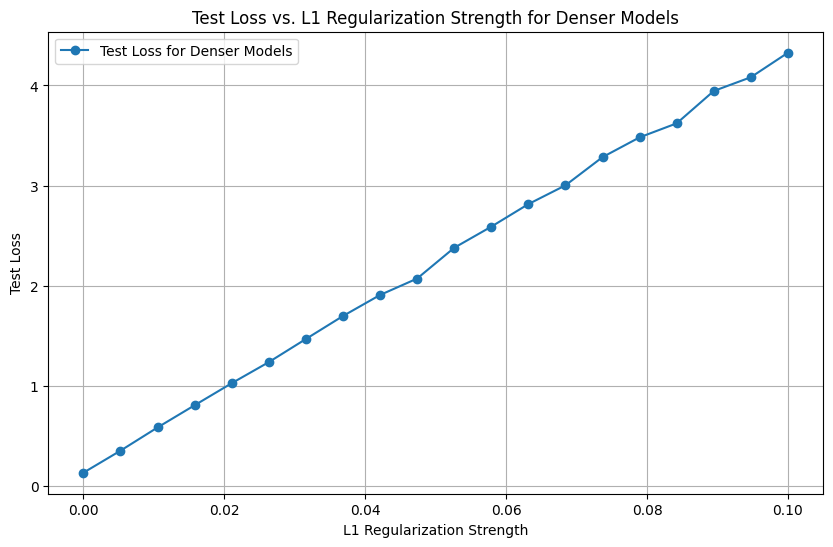

In [ ]:
# Define the denser architecture for the models
input_size = train_X.shape[1]  # Number of features
output_size = 1  # For regression
hidden_layers = [50, 50, 50]  # 3 hidden layers with 50 neurons each
loss_function = 'mse'  # Mean Squared Error for regression
learning_rate = 0.01  # Learning rate for training

# Store the test loss for each denser model to analyze later
test_losses_dense = []

# Train and test a denser model for each L1 strength
for l1_reg in l1_strengths:
    print(f"\nTraining denser model with L1 regularization strength: {l1_reg}")
    model_dense = FullyConnectedNeuralNetwork(input_size, output_size, hidden_layers, loss_function, learning_rate, l1_reg, l2_reg=0.0)

    # Train the denser model
    train_model(model_dense, train_X, train_y, epochs=100)  # Train model function as defined earlier

    # Test the denser model
    test_loss_dense = test_model(model_dense, test_X, test_y)  # Test model function as defined earlier
    test_losses_dense.append(test_loss_dense)

# Plotting the test losses of the denser models against L1 regularization strengths
plt.figure(figsize=(10, 6))
plt.plot(l1_strengths, test_losses_dense, '-o', label='Test Loss for Denser Models')
plt.title('Test Loss vs. L1 Regularization Strength for Denser Models')
plt.xlabel('L1 Regularization Strength')
plt.ylabel('Test Loss')
plt.grid(True)
plt.legend()
plt.show()

Testing L2

In [ ]:
hidden_layers = [50, 50, 50]  # 3 hidden layers with 50 neurons each


Training denser model with L2 regularization strength: 0.0
Epoch 0, Loss: 0.19809367827339547
Epoch 10, Loss: 0.18499328732446843
Epoch 20, Loss: 0.1742801654642406
Epoch 30, Loss: 0.16552046578587198
Epoch 40, Loss: 0.15835799837449172
Epoch 50, Loss: 0.15250152956887628
Epoch 60, Loss: 0.1477129279474968
Epoch 70, Loss: 0.1437974857497111
Epoch 80, Loss: 0.1405959939166546
Epoch 90, Loss: 0.13797827698105639
Test Loss: 0.13463497958141735

Training denser model with L2 regularization strength: 0.005263157894736842
Epoch 0, Loss: 0.1980955114307546
Epoch 10, Loss: 0.18499464018861925
Epoch 20, Loss: 0.17428314783327153
Epoch 30, Loss: 0.1655244615679856
Epoch 40, Loss: 0.15836256216288008
Epoch 50, Loss: 0.1525063505150758
Epoch 60, Loss: 0.14771779333892268
Epoch 70, Loss: 0.14380224820973844
Epoch 80, Loss: 0.14060055823346532
Epoch 90, Loss: 0.13798257525993332
Test Loss: 0.13463971630578084

Training denser model with L2 regularization strength: 0.010526315789473684
Epoch 0, Loss

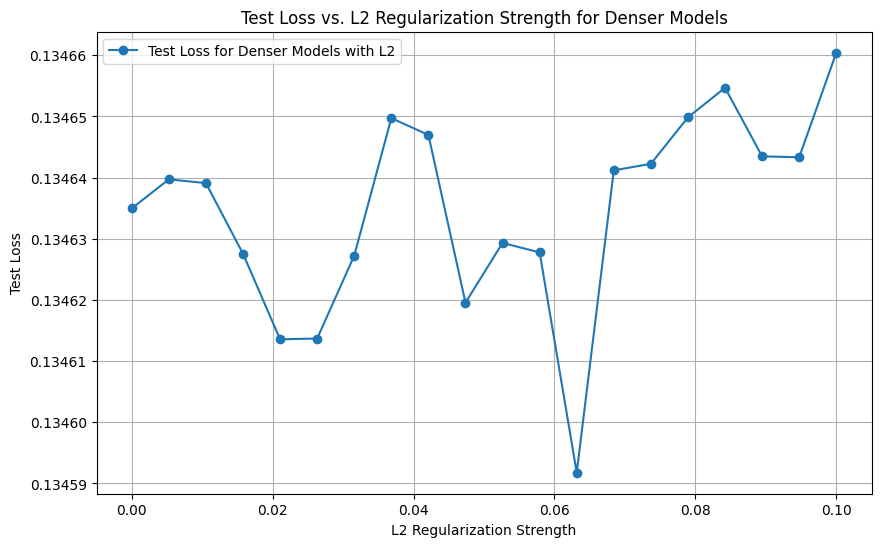

In [ ]:
# Define a range of L2 regularization strengths
l2_strengths = np.linspace(0.0, 0.1, 20)  # 20 values from 0.0 to 0.1

# Store the test loss for each denser model with different L2 regularization strengths
test_losses_l2 = []

# Train and test a denser model for each L2 strength
for l2_reg in l2_strengths:
    print(f"\nTraining denser model with L2 regularization strength: {l2_reg}")
    model_l2 = FullyConnectedNeuralNetwork(input_size, output_size, hidden_layers, loss_function, learning_rate, l1_reg=0.0, l2_reg=l2_reg)

    # Train the model with L2 regularization
    train_model(model_l2, train_X, train_y, epochs=100)

    # Test the model with L2 regularization
    test_loss_l2 = test_model(model_l2, test_X, test_y)
    test_losses_l2.append(test_loss_l2)

# Plotting the test losses of the denser models against L2 regularization strengths
plt.figure(figsize=(10, 6))
plt.plot(l2_strengths, test_losses_l2, '-o', label='Test Loss for Denser Models with L2')
plt.title('Test Loss vs. L2 Regularization Strength for Denser Models')
plt.xlabel('L2 Regularization Strength')
plt.ylabel('Test Loss')
plt.grid(True)
plt.legend()
plt.show()